In [1]:
import os
import numpy as np
import torch

In [2]:
from utils import load_model
model, _ = load_model('pretrained/tsp_20')
model.eval()  # Put in evaluation mode to not track gradients

np.random.seed(1234)
xy = np.random.rand(10, 2)

def make_oracle(model, xy, temperature=1.0):
    
    num_nodes = len(xy)
    
    xyt = torch.tensor(xy).float()[None]  # Add batch dimension
    
    with torch.no_grad():  # Inference only
        embeddings = model.encoder(model._init_embed(xyt))

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        fixed = model._precompute(embeddings)
    
    def oracle(tour):
        with torch.no_grad():  # Inference only
            # Input tour with 0 based indices
            # Output vector with probabilities for locations not in tour
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                step_context = model.W_placeholder
            else:
                step_context = torch.cat((embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1)

            # Compute query = context node embedding, add batch and step dimensions (both 1)
            query = fixed.context_node_projected + model.decoder.project_step_context(step_context[None, None, :])

            # Create the mask and convert to bool depending on PyTorch version
            mask = torch.zeros(num_nodes, dtype=torch.uint8) > 0
            mask[tour] = 1
            mask = mask[None, None, :]  # Add batch and step dimension

            log_p, _ = model.decoder._get_attention_glimpse(query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask)
            p = torch.softmax(log_p / temperature, -1)[0, 0]
            assert (p[tour] == 0).all()
            assert (p.sum() - 1).abs() < 1e-5
            #assert np.allclose(p.sum().item(), 1)
        return p.numpy()
    
    return oracle, xyt, embeddings
        


oracle, input, embeddings = make_oracle(model, xy)

sample = False
tour = []
tour_p = []
while(len(tour) < len(xy)):
    p = oracle(tour)
    
    if sample:
        # Advertising the Gumbel-Max trick
        g = -np.log(-np.log(np.random.rand(*p.shape)))
        i = np.argmax(np.log(p) + g)
        # i = np.random.multinomial(1, p)
    else:
        # Greedy
        i = np.argmax(p)
    tour.append(i)
    tour_p.append(p)
    
print(tour)

odict_keys(['W_placeholder', 'init_embed.weight', 'init_embed.bias', 'embedder.layers.0.0.module.W_query', 'embedder.layers.0.0.module.W_key', 'embedder.layers.0.0.module.W_val', 'embedder.layers.0.0.module.W_out', 'embedder.layers.0.1.normalizer.weight', 'embedder.layers.0.1.normalizer.bias', 'embedder.layers.0.1.normalizer.running_mean', 'embedder.layers.0.1.normalizer.running_var', 'embedder.layers.0.1.normalizer.num_batches_tracked', 'embedder.layers.0.2.module.0.weight', 'embedder.layers.0.2.module.0.bias', 'embedder.layers.0.2.module.2.weight', 'embedder.layers.0.2.module.2.bias', 'embedder.layers.0.3.normalizer.weight', 'embedder.layers.0.3.normalizer.bias', 'embedder.layers.0.3.normalizer.running_mean', 'embedder.layers.0.3.normalizer.running_var', 'embedder.layers.0.3.normalizer.num_batches_tracked', 'embedder.layers.1.0.module.W_query', 'embedder.layers.1.0.module.W_key', 'embedder.layers.1.0.module.W_val', 'embedder.layers.1.0.module.W_out', 'embedder.layers.1.1.normalizer.w

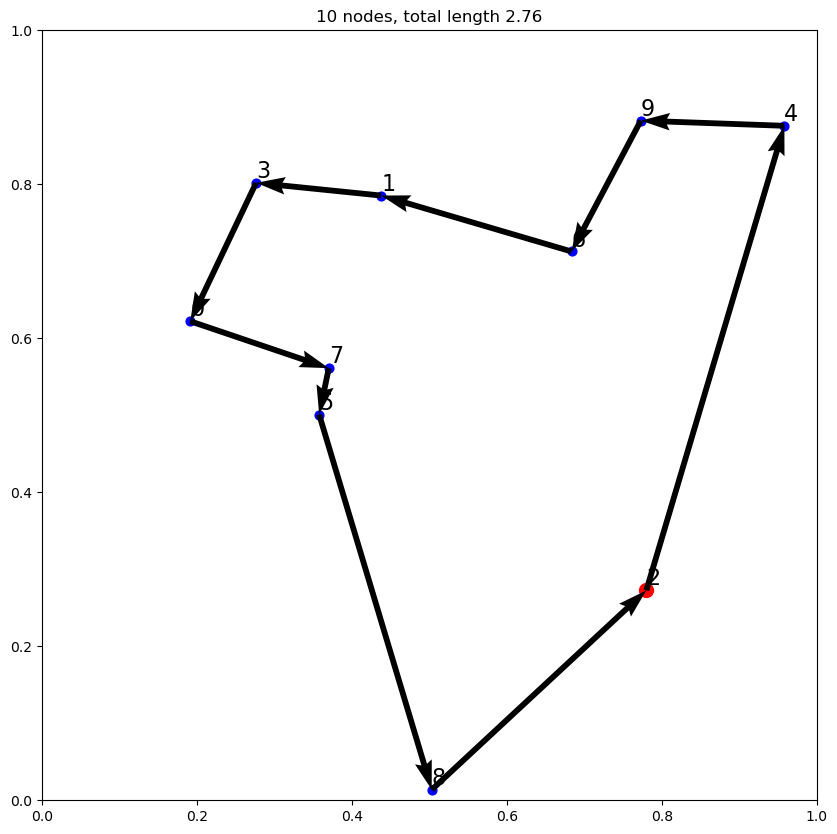

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes with node index
    for i, (x, y) in enumerate(zip(xs, ys)):
        ax1.scatter(x, y, s=40, color='blue')
        ax1.annotate(str(tour[i]), (x, y), fontsize=16, ha='left', va='bottom')

    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_tsp(xy, tour, ax)


MovieWriter imagemagick unavailable; using Pillow instead.



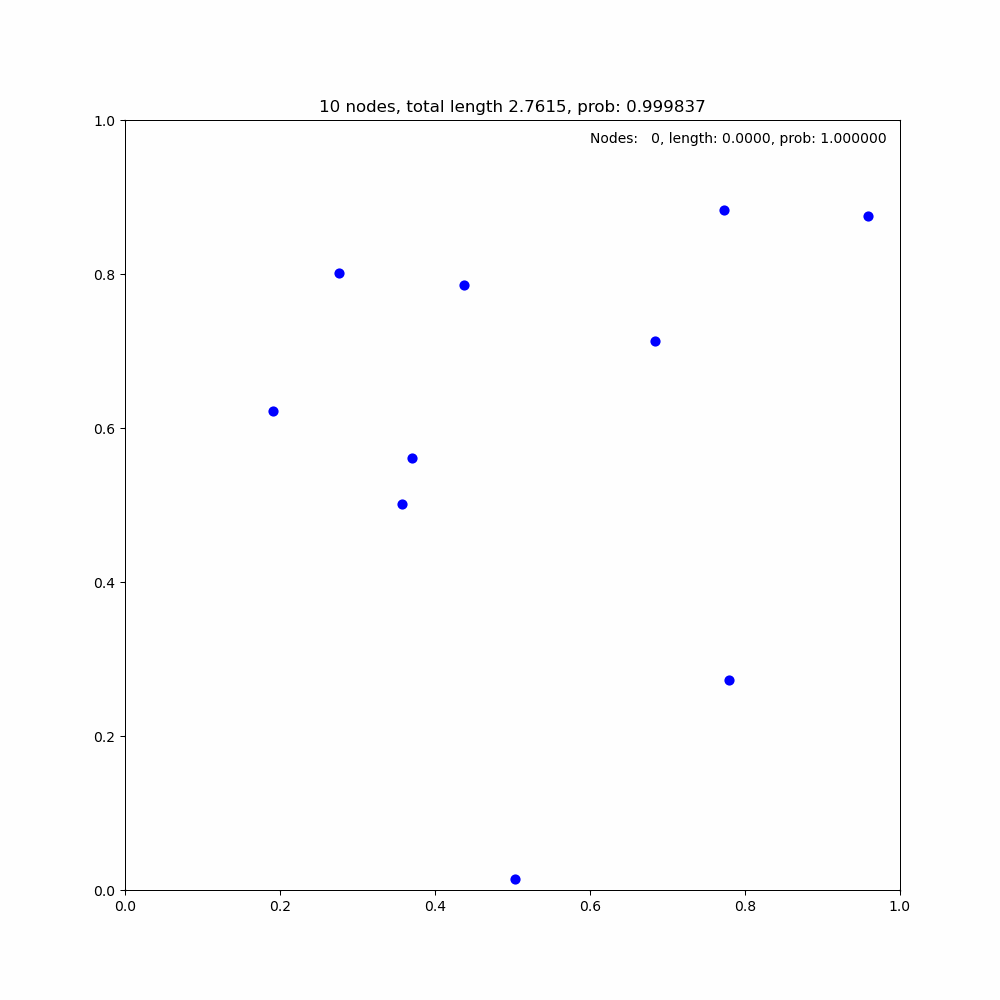

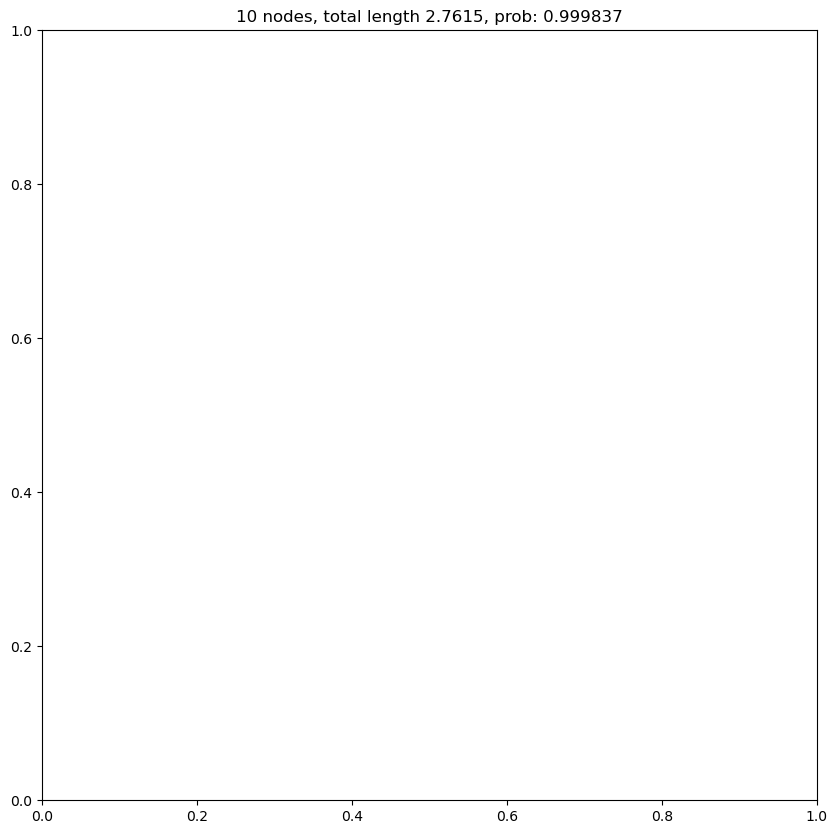

In [4]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import HTML
import base64

from celluloid import Camera  # pip install celluloid

def format_prob(prob):
    return ('{:.6f}' if prob > 1e-5 else '{:.2E}').format(prob)

def plot_tsp_ani(xy, tour, tour_p=None, max_steps=1000):
    n = len(tour)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    camera = Camera(fig)

    total_length = 0
    cum_log_prob = 0
    for i in range(n + 1):
        for plot_probs in [False] if tour_p is None or i >= n else [False, True]:
            # Title
            title = 'Nodes: {:3d}, length: {:.4f}, prob: {}'.format(
                i, lengths[i - 2] if i > 1 else 0., format_prob(np.exp(cum_log_prob))
            )
            ax1.text(0.6, 0.97, title, transform=ax.transAxes)

            # First print current node and next candidates
            ax1.scatter(xs, ys, s=40, color='blue')

            if i > 0:
                ax1.scatter([xs[i - 1]], [ys[i - 1]], s=100, color='red')
            if i > 1:
                qv = ax1.quiver(
                    xs[:i-1],
                    ys[:i-1],
                    dx[:i-1],
                    dy[:i-1],
                    scale_units='xy',
                    angles='xy',
                    scale=1,
                )
            if plot_probs:
                prob_rects = [Rectangle((x, y), 0.01, 0.1 * p) for (x, y), p in zip(xy, tour_p[i]) if p > 0.01]
                pc = PatchCollection(prob_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
                ax1.add_collection(pc)
            camera.snap()
        if i < n and tour_p is not None:
            # Add cumulative_probability
            cum_log_prob += np.log(tour_p[i][tour[i]])
        if i > max_steps:
            break

    # Plot final tour
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    if tour_p is not None:
        # Note this does not use stable logsumexp trick
        cum_log_prob = format_prob(np.exp(sum([np.log(p[node]) for node, p in zip(tour, tour_p)])))
    else:
        cum_log_prob = '?'
    ax1.set_title('{} nodes, total length {:.4f}, prob: {}'.format(len(tour), lengths[-1], cum_log_prob))
    
    camera.snap()
    
    return camera 

    
animation = plot_tsp_ani(xy, tour, tour_p).animate(interval=500)
animation.save('../images/tsp/tsp.gif', writer='imagemagick', fps=2)  # requires imagemagick
# compress by running 'convert tsp.gif -strip -coalesce -layers Optimize tsp.gif'
# HTML(animation.to_html5_video())  # requires ffmpeg
b64 = base64.b64encode(open('../images/tsp/tsp.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [5]:
import seaborn as sns
# Function to set the color of labels
def set_label_colors(labels, colors):
    for label, color in zip(labels, colors):
        label.set_color(color)

def fix_naming(name):
    if name.split("_")[0] == "input":
        return "Original Input Nodes"
    return "Encoded Node Embeddings"

def plot_encoder_data(figures, ordered_nodes, node_colors=None, title="Distance Matrix of the TSP"):
    fig, axs = plt.subplots(1, len(figures), figsize=(20, 10))
    fig.suptitle(title, fontsize=24)

    # Create the heatmaps
    for index, (name, figure) in enumerate(figures.items()):
        ax = axs[index]
        ax.set_title(fix_naming(name), fontsize=22)

        # Create heatmap using seaborn
        cmap = plt.get_cmap('coolwarm')
        sns.heatmap(figure, cmap=cmap, annot=True, fmt=".2f", linewidths=.05, ax=ax,
                    xticklabels=ordered_nodes, yticklabels=ordered_nodes, cbar=False)

        # Set the xticklabels and yticklabels
        xticklabels = ax.get_xticklabels()
        ax.xaxis.set_tick_params(labelsize=16)
        yticklabels = ax.get_yticklabels()
        ax.yaxis.set_tick_params(labelsize=16)

    if node_colors is not None:
        set_label_colors(xticklabels, node_colors)
        set_label_colors(yticklabels, node_colors)

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    # Add colorbar for reference
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
    fig.colorbar(ax.get_children()[0], cax=cbar_ax)
    
    plt.savefig("../images/tsp/tsp_distance_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def plot_attention_weights(model):

    for layer_idx in range(model.n_encode_layers):
        attention_layer = model.encoder.layers[layer_idx][0].module
        # First instance of the batch
        att = attention_layer.get_attention_weights()[:, 0, :, :].detach().cpu().numpy()

        # Plot the attention weights
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f"Layer {layer_idx + 1} - Attention Weights", fontsize=24)

        for head in range(attention_layer.num_heads):
            ax = axs[head // 4, head % 4]
            # Use seaborn heatmap for the plot
            cmap = plt.get_cmap('coolwarm_r')
            sns.heatmap(att[head], annot=True, fmt=".2f", linewidths=.05, cmap=cmap, ax=ax, cbar=False, fontsize=18)

            # Set axis labels and title
            ax.set_xlabel("To Node", fontsize=22)
            ax.set_ylabel("From Node", fontsize=22)
            ax.set_title(f"Attention Head {head + 1}", fontsize=22)
            ax.xaxis.set_tick_params(labelsize=16)
            ax.yaxis.set_tick_params(labelsize=16)

        # Adjust spacing between subplots
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

        # Add colorbar for reference
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar

        fig.colorbar(ax.get_children()[0], cax=cbar_ax)
        cbar_ax.set_ylabel("Attention Weight", fontsize=20)

        # Convert the figure to a numpy array
        plt.show()


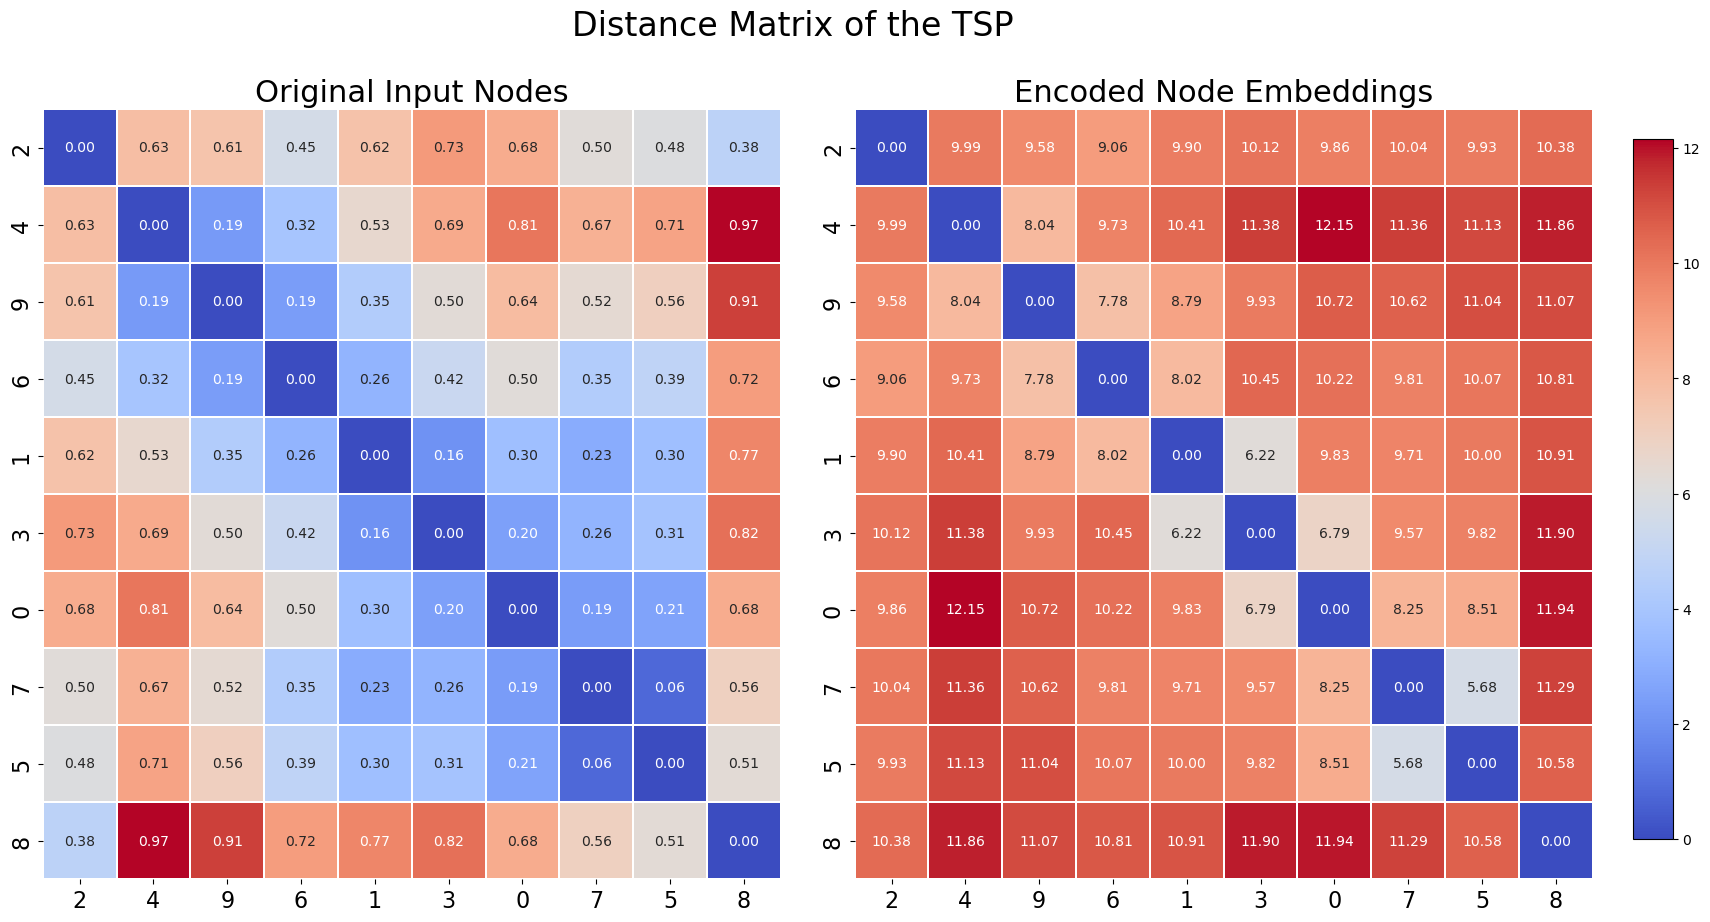

In [6]:
model_ = model

encoder_distance = {
    "input_distance": (
        input[0, :, None, :]-
        input[0, None, :, :]
    ).norm(p=2, dim=-1),
    "embedding_distance": (
        embeddings[0, :, None, :]
        - embeddings[0, None, :, :]
    ).norm(p=2, dim=-1),
}

ordered_figures = {k: v[tour][:, tour] for k, v in encoder_distance.items()}
plot_encoder_data(ordered_figures, tour)
# plot_attention_weights(model_)

In [7]:
tour

[2, 4, 9, 6, 1, 3, 0, 7, 5, 8]

In [8]:
model

AttentionModel(
  (init_embed): Linear(in_features=2, out_features=128, bias=True)
  (embedder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, m

In [9]:
xs, ys = xy[tour].transpose()
xs, ys = xy[tour].transpose()
dx = np.roll(xs, -1) - xs
dy = np.roll(ys, -1) - ys

/Users/kleiofragkedaki/miniconda3/envs/rl_thesis_2023/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_47296/3839733983.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', n_clusters)


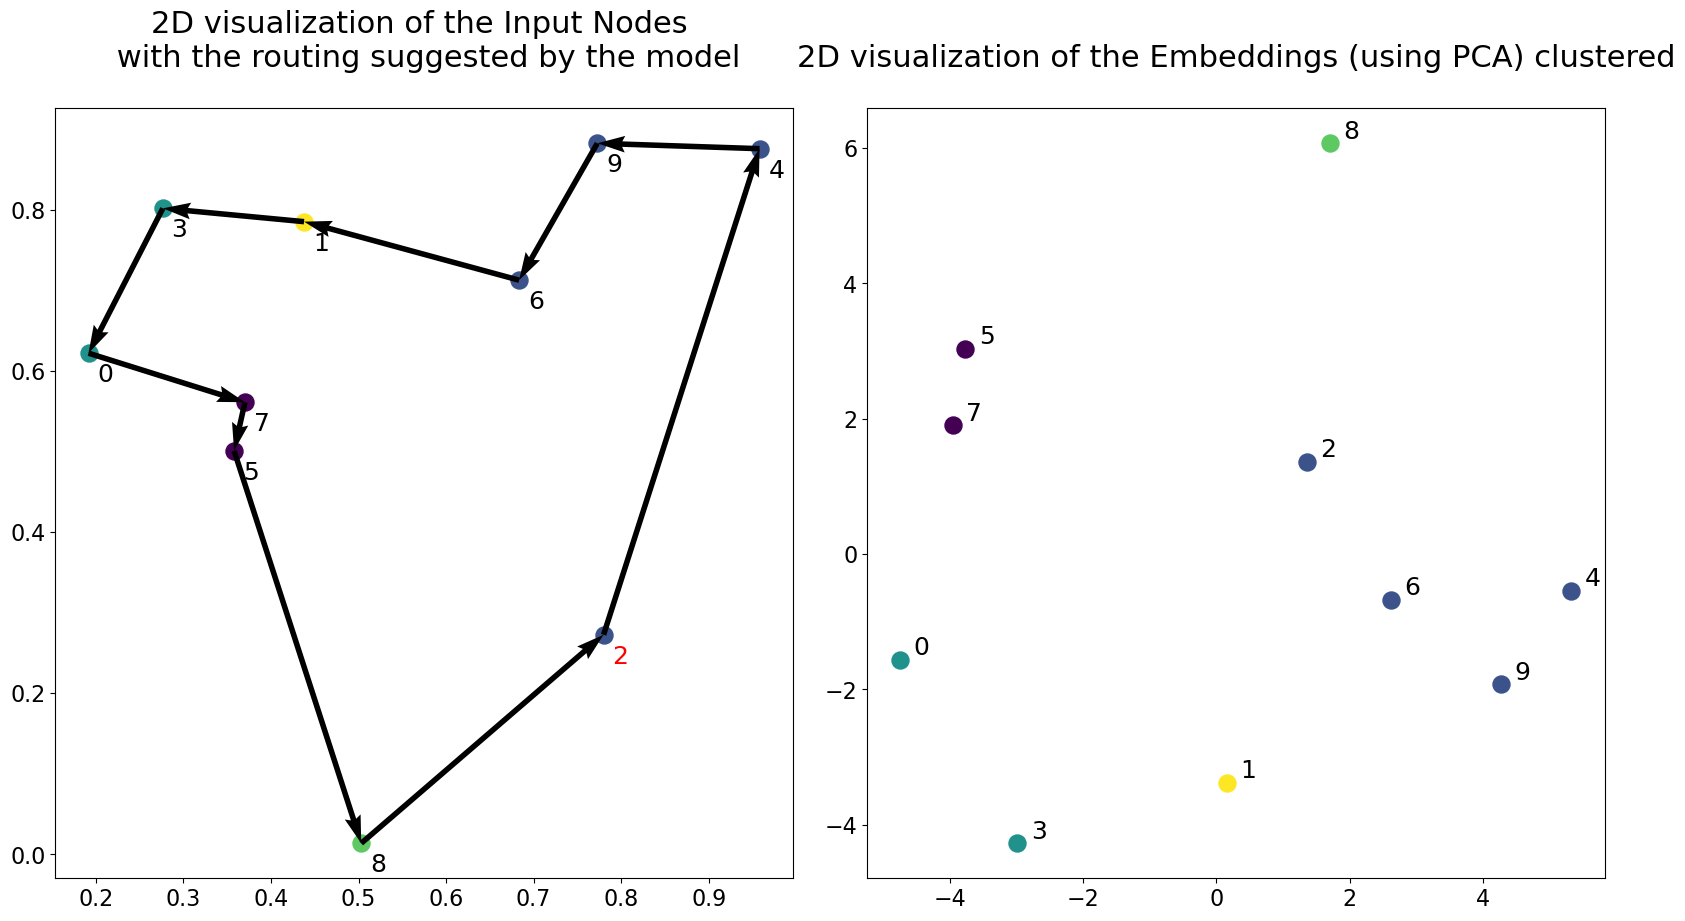

In [64]:
from sklearn.cluster import KMeans
from matplotlib import cm
import numpy as np

# 1. Apply KMeans clustering on the embeddings
n_clusters = 5  # choose the number of clusters you'd like
kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit_predict(embeddings_2d)

# Create a colormap
colormap = cm.get_cmap('viridis', n_clusters)

# 2. Visualize the nodes colored by their cluster label
fig, ax = plt.subplots(1, 2, figsize=(20,10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.title("Traveling Salesman Problem", fontsize=24)

for i, (x, y) in enumerate(zip(xy[:, 0], xy[:, 1])):
    ax[0].scatter(x, y, s=150, color=colormap(cluster_labels[i]))
    if i == 2: ax[0].annotate(str(i), (x+0.01, y-0.042), fontsize=18, ha='left', va='bottom', color='red')
    else: ax[0].annotate(str(i), (x+0.01, y-0.042), fontsize=18, ha='left', va='bottom')
    ax[0].set_title("2D visualization of the Input Nodes \n with the routing suggested by the model\n",  fontsize=22)

# Adjust this part to use the cluster colors
for i, (x, y) in enumerate(zip(embeddings_2d[:, 0], embeddings_2d[:, 1])):
    ax[1].scatter(x, y, s=150, color=colormap(cluster_labels[i]))
    ax[1].annotate(str(i), (x+0.2, y), fontsize=18, ha='left', va='bottom')
    ax[1].set_title("2D visualization of the Embeddings (using PCA) clustered\n", fontsize=22)

ax[0].quiver(
    xs, ys, 
    dx, dy,
    scale_units='xy',
    angles='xy',
    scale=1
)

ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

plt.savefig("tsp_2d_projection.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
tour

[2, 4, 9, 6, 1, 3, 0, 7, 5, 8]

In [12]:
input.shape, embeddings.shape

(torch.Size([1, 10, 2]), torch.Size([1, 10, 128]))

In [13]:
distances_between_inputs = torch.tensor(input[:, None, :] - input[:, :, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)
distances_between_outputs = torch.tensor(embeddings[:, None, :] - embeddings[:, :, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)

/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_47296/1993870113.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distances_between_inputs = torch.tensor(input[:, None, :] - input[:, :, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)
/var/folders/gl/_6q874612pv_5g7n_b2_wbb40000gn/T/ipykernel_47296/1993870113.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  distances_between_outputs = torch.tensor(embeddings[:, None, :] - embeddings[:, :, None]).clone().detach().norm(p=2, dim=-1).reshape(-1)


In [14]:
distances_between_inputs.shape, distances_between_outputs.shape

(torch.Size([100]), torch.Size([100]))

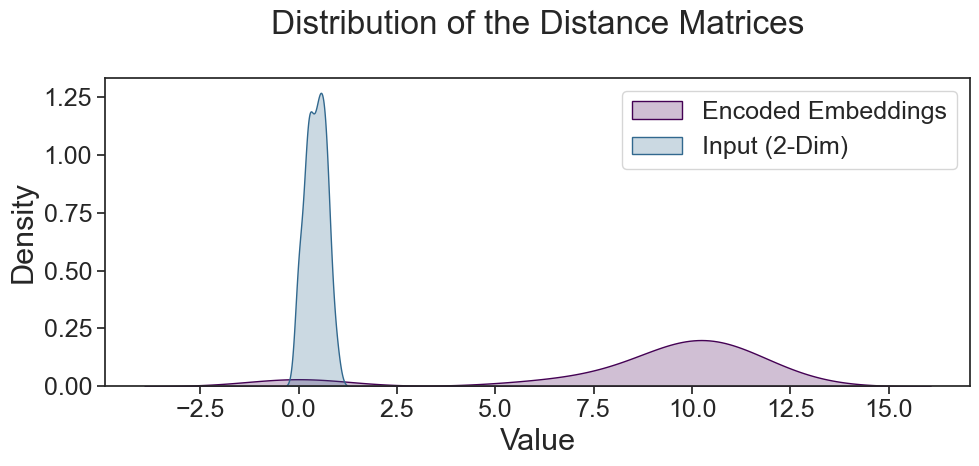

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

input_np = encoder_distance["input_distance"].flatten()
embeddings_np = encoder_distance["embedding_distance"].flatten()

# Create a single subplot
fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # Adjusted to have 4 colors

# Plot KDEs for the data
sns.kdeplot(data=embeddings_np, ax=ax, fill=True, legend=True, color=colors[0], label='Encoded Embeddings')
sns.kdeplot(data=input_np, ax=ax, fill=True, legend=True, color=colors[1], label='Input (2-Dim)')

# Set title and labels
ax.set_title(f'Distribution of the Distance Matrices\n', size=24)
ax.set_xlabel('Value', size=22)
ax.set_ylabel('Density', size=22)
ax.tick_params(axis='both', labelsize=18)  
ax.legend(fontsize=18) 

# Display plot
plt.tight_layout()
plt.savefig(f"distances_distribution_tsp.png", dpi=300, bbox_inches='tight')
plt.show()


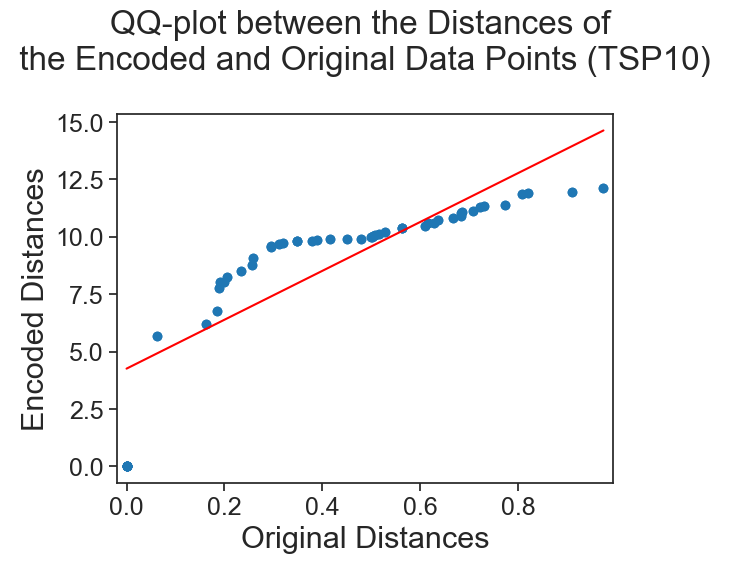

In [117]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the existence of distances_between_inputs and distances_between_outputs
pp_x = sm.ProbPlot(distances_between_inputs)
pp_y = sm.ProbPlot(distances_between_outputs)

# Set the Seaborn style
sns.set_style("ticks")
# sns.set_context("notebook", font_scale=1.5)  # Adjust the font_scale value for your needs

# Create the QQ plot
fig, ax = plt.subplots()

# Generate QQ plot
qq = sm.qqplot_2samples(pp_x, pp_y, line='r', ax=ax)

plt.title("QQ-plot between the Distances of \n the Encoded and Original Data Points (TSP10) \n", size=24)
ax.set_xlabel("Original Distances", fontsize=22)
ax.set_ylabel("Encoded Distances", fontsize=22)
ax.tick_params(axis='both', labelsize=18)

# Show the plot
plt.savefig("qq_plot_tsp.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [118]:
from scipy.interpolate import interp1d

# Get the actual points on the QQ plot
actual_points = qq.axes[0].lines[0].get_xydata()

# Get the regression line
reg_line = qq.axes[0].lines[1].get_xydata()

f = interp1d(reg_line[:, 0], reg_line[:, 1], kind='linear')
regression_y = f(actual_points[:, 0])

# Calculate the differences 
difference = actual_points - np.column_stack((reg_line[:, 0], regression_y))
difference2 = actual_points - reg_line

distance = torch.tensor(difference).norm(p=2, dim=-1)
distance2 = torch.tensor(difference2).norm(p=2, dim=-1)

# Print differences?
print("Mean: ", distance.mean().item(), "Median: ", distance.median().item(), "Std: ", distance.std().item())
print(distance2.mean(), distance2.median())


Mean:  1.3740566910189338 Median:  0.9967238199923347 Std:  1.177937340311549
tensor(1.3741, dtype=torch.float64) tensor(0.9967, dtype=torch.float64)
